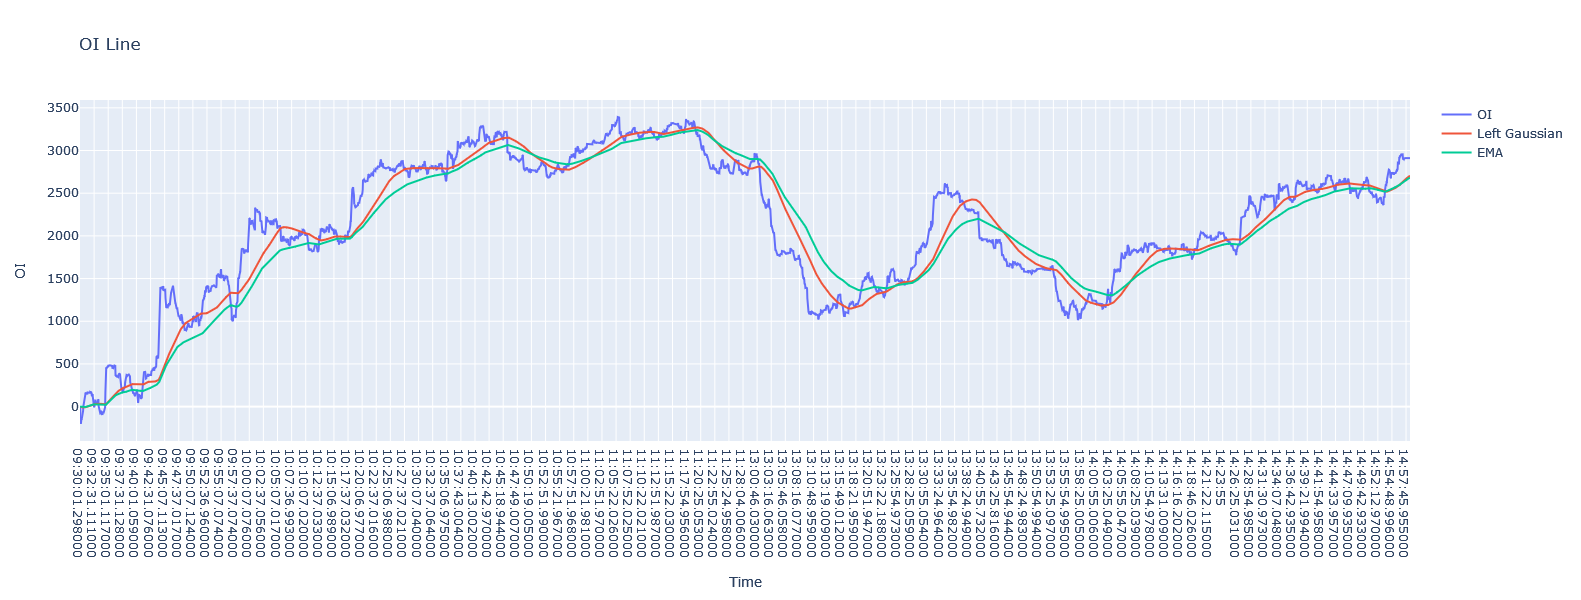

In [64]:
# 这里研究一下各种滤波器的效果，我们载入一列简单的 OI 数列

import numpy as np
import pandas as pd
import scipy.signal as ssig
import plotly.graph_objects as go
import plotly.offline as pyo

def read_oi():
    df = pd.read_csv('../input/strike_oi_diff_159915_20241021.csv')
    df_clip = df.loc[df['strike'] == 2.15]
    se_ts = pd.to_datetime(df_clip['dt'])
    se_ts = se_ts.dt.time
    se_oi = df_clip['oi_diff_c'] - df_clip['oi_diff_p']
    return se_ts, se_oi

# scipy.signal.windows.gaussian(wsize, sigma)
# 输出一个高斯分布的长度 wsize 的数组，中心值 1，标准差 sigma
# 如果用作卷积核那么需要让数组总和为 1，处理方法是 arr /= np.sum(arr)

def full_gaussian(sig, wsize, sigma):
    gau = ssig.windows.gaussian(wsize, sigma)
    gau /= np.sum(gau)
    return np.convolve(sig, gau, mode='same')

def left_gaussian(sig, wsize, sigma):
    gau = ssig.windows.gaussian(wsize, sigma)
    # 卷积运算是信号的左边对应卷积核的右边，所以单纯左边信号的卷积要清零左半边的卷积核
    gau[:wsize // 2] = 0
    gau /= np.sum(gau)
    return np.convolve(sig, gau, mode='same')

se_ts, se_oi = read_oi()
gau_wsize = 300
gau_sigma = 120
se_oi_gau_1 = full_gaussian(se_oi, gau_wsize, gau_sigma)
se_oi_gau_2 = left_gaussian(se_oi, gau_wsize, gau_sigma)
se_oi_ema = se_oi.ewm(gau_sigma, adjust=False).mean()

# 滤波的目标是在减少折痕的同时尽量不滞后，需要做到这两者的平衡
# 在这上面，Left Gaussian 比 EMA 更好。

line_plot = go.Figure()
line_plot.add_trace(go.Scatter(x=se_ts, y=se_oi, mode='lines', name='OI'))
# line_plot.add_trace(go.Scatter(x=se_ts, y=se_oi_gau_1, mode='lines', name='Full Gaussian'))
line_plot.add_trace(go.Scatter(x=se_ts, y=se_oi_gau_2, mode='lines', name='Left Gaussian'))
line_plot.add_trace(go.Scatter(x=se_ts, y=se_oi_ema, mode='lines', name='EMA'))
line_plot.update_layout(
    title='OI Line',
    xaxis_title='Time',
    yaxis_title='OI',
    # xaxis_tickangle=-45,
    height=600,
)

# line_plot.show()
pyo.iplot(line_plot)


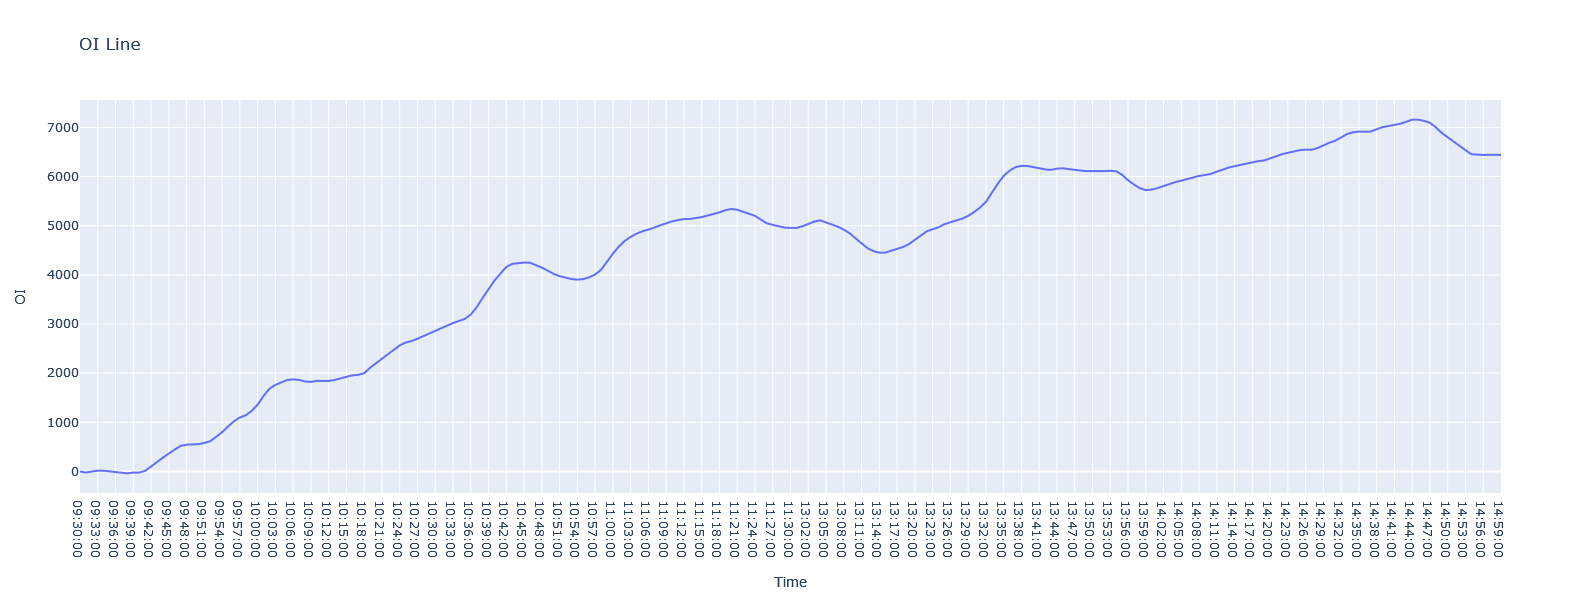

In [65]:
# 看一下先高斯然后再采样分钟级别的效果

import pandas as pd
df = pd.read_csv('../dsp/oi_c_grid.csv')
df = df[~df.isna().any(axis=1)]
se_ts = pd.to_datetime(df['dt']).dt.time
se_oi = df['2.15']

line_plot = go.Figure()
line_plot.add_trace(go.Scatter(x=se_ts, y=se_oi, mode='lines', name='OI'))
line_plot.update_layout(
    title='OI Line',
    xaxis_title='Time',
    yaxis_title='OI',
    height=600,
)
pyo.iplot(line_plot)

In [41]:
import scipy.signal as ssig
import numpy as np
print(ssig.windows.gaussian(10, 1))
print(np.convolve([1, 2, 3], [1, 0, 0], mode='valid'))

[4.00652974e-05 2.18749112e-03 4.39369336e-02 3.24652467e-01
 8.82496903e-01 8.82496903e-01 3.24652467e-01 4.39369336e-02
 2.18749112e-03 4.00652974e-05]
[3]
